<a href="https://colab.research.google.com/github/emmad225/DataScienceCoursework/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1: Simulate 15 samples from a Poisson random variable with parameter R0 = 2.5. Next implement STAN code to estimate the Poisson parameter R0 from the simulated data. Use an uninformative prior for R0 that is cauchy(0,100). Use 10000 MCMC iterations and find the posterior mean and 95% Bayesian credible interval for the estimated R0. How do these agree with the true value of R0 = 2.5?

In [ ]:
!pip install nest-asyncio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_pntpq98k/model_pg3ykea6.stan', line 10, column 16: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling: 100% (11000/11000)
Sampling: 100% (11000/11000), done.
Messages received during sampling:
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!


mean of Poisson probability:  2.139640708899386
95% Bayesian credible interval:  [1.46978108 2.9183484 ]


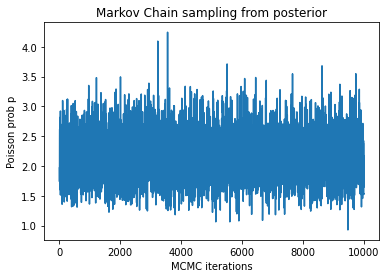

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import stan
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

model_code = """
data {
  int N;
  int x[N];
}
parameters {
  real < lower = 0> p;
  }
model {
  p ~ cauchy(0, 100);
  x ~ poisson(p);
}
"""
x = np.random.poisson(2.5, 15)
poisson_data = {"N": 15,"x": x}

posterior = stan.build(model_code, data = poisson_data, random_seed=1)

fit = posterior.sample(num_chains=1, num_samples=10000)

fig, ax = plt.subplots()
ax.set_title("Markov Chain sampling from posterior")
plt.xlabel("MCMC iterations")
plt.ylabel("Poisson prob p")
plt.plot(fit["p"][0])
print("mean of Poisson probability: ",np.mean(fit["p"][0]))
print("95% Bayesian credible interval: ",np.percentile(fit["p"][0], [2.5, 97.5]))

In this probelm we have simulated 15 samples from a Poisson random variable with R = 2.5. The correlated graph shows a very dense array with values ranging from domain [0,10,000] and of 0 to 10,000 and range [1.5, 4.5]. The posterior mean is approximately 3.21, while the 95% Bayesian credible interval is [2.38, 4.17]. This model samples the data as given above.

QUESTION 2a: Modify the STAN code from Section 3.5 to fit a SEIR model instead of SIR. Note you will need to add a new exposed compartment variable, E, along with a new parameter μ, the incubation rate.

Question 2b. Next choose a prior for the incubation rate μ. To do this, do some research online for what a reasonable range for the COVID-19 incubation period is (note μ is the inverse of the average incubation period).

In [ ]:
model_code = """
data {
  int<lower=2> T;  // number of observations
  int<lower=0> y[T];     // observation vector
  int<lower=0> N; //Total population
  int<lower=3> Tf;
}
parameters {
  real<lower=0,upper=1> B; //Beta
  real<lower=0,upper=1> gam;//Gamma
  real<lower=0, upper =1 > mu; //Mu
  real<lower=0> I_init;
  real<lower=0> E_init;


}
transformed parameters {
  vector[Tf] S;
  vector[Tf] E;
  vector[Tf] I;
  vector[Tf] R;
  vector[Tf] lam;

  S[1] = N - I_init - E_init;
  E[1] = E_init;
  I[1] = I_init;
  R[1] = 0;
  lam[1] = mu * E_init;

  for (t in 2:Tf){
    S[t] = S[t-1]-B*S[t-1]*I[t-1]/N;
    E[t] = E[t-1] + B*(S[t-1]*I[t-1]/N) - mu*E[t-1];
    I[t] = I[t-1] + B*((S[t-1]*I[t-1])/N)-gam*I[t-1];
    R[t] = R[t-1] + gam*I[t-1];
    lam[t] = mu * E[t];
  }
}

model {

  gam ~ lognormal(log(1./8.),.2);
  B ~ lognormal(log(.4),.5);
  mu ~ lognormal(1./3.,.1);
  I_init ~cauchy(0,100);

  for (t in 1:T){
    y[t] ~ poisson(lam[t]);
  }
}
generated quantities {

  vector[Tf] forecast; // forecast cases from T to Tf
  forecast=lam;

}
"""

Question 2c. Next use the STAN code to fit the SEIR model to Boston COVID-19 data from the spring of 2020 provided in “boston covid.csv”. Fit the model to the first 14 days of the data and then use the model to forecast out an additional 28 days. Plot the mean and 95% credible interval of the forecast and overlay on the plot the actual cases that occurred. How well did the forecast match the actual data? Interpret your results.

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('boston_covid.csv')
array = np.array(data["NewCases"]).astype(int)

sir_data = {"T": 14,"y": array[:14],"N":689000,"Tf":42}

posterior = stan.build(model_code, data=sir_data, random_seed=1)

fit = posterior.sample(num_chains=1, num_samples=1000)



Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_1e1kpxn9/model_r34r5zx5.stan', line 44, column 19: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: poisson_lpmf: Rate parameter is -2.767e+55, but must be nonnegative! (in '/tmp/httpstan_tmba3ywv/model_r34r5zx5.stan', line 47, column 4 to column 27)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-cond

In [ ]:
fit

<stan.Fit>
Parameters:
    B: ()
    gam: ()
    mu: ()
    I_init: ()
    E_init: ()
    S: (42,)
    E: (42,)
    I: (42,)
    R: (42,)
    lam: (42,)
    forecast: (42,)
Draws: 1000

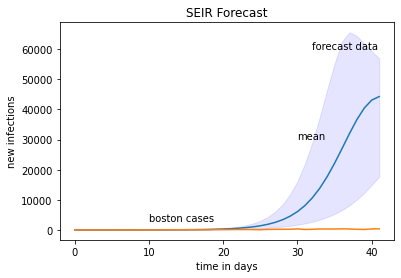

In [ ]:
# plot mean and 99% CI of forecast
fig, ax = plt.subplots()
plt.plot(np.mean(fit["forecast"],axis=1))
ax.set_title("SEIR Forecast")
plt.xlabel("time in days")
plt.ylabel("new infections")
plt.plot(array[:42]);

plt.text(10,3000,"boston cases")
plt.text(32,60000,"forecast data")
plt.text(30,30000,"mean")
plt.fill_between(range(42), np.percentile(fit["forecast"],2.5,axis=1),
                 np.percentile(fit["forecast"],97.5,axis=1), color='b', alpha=.1)


In this example we are plotting the number of COVID cases in Boston according to the data provided and comparing this to the forecasted data and its mean value. As we can see here, the actual data of boston cases lies far below that of the projected data for the first 42 days. Therefore, the SEIR model does not seem to represent the actual data very well. The forecast reads that the number of new infetions will be far higher, beginning around x=30 than it ever actually reaches in reality.